Jump Diffusion

From the general stock price, we can sometimes see sudden increase or drop which show that the stock price might not be constant assumed under Black-Scholes model. We then might wonder, will the option pricing under stock prices including jumps more close to the market price? The answer is yes and the reason is that stock prices under jump diffusion compared to GBM show higher variance, which is more identical to the market stock price. 

In this project, the assumption of continuous stock price will be released. The jump diffusion model which was introduce by Merton(1976) adds a log-normally distributed jump component to the geometric Brownian Motion (GBM). 

Then Monte Carlo simulation under jump diffusion model will be run to generate stock prices which are finally used for option price. After that, there will be a comparison among option price under market, GBM and jump diffusion.

The results show that under each strike price, the option prices under jump diffusion are closer to the market prices than the option prices under GBM, which corresponds to our guess.

Belowing mainly divides into 3 parts:

 • Functions and classes for jump diffusion (Based on 'Python for Finance' by Yves Hilpisch)
 
 • Realization of Monte Carlo simulation and Option Pricing
 
 • Comparison of option prices


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import datetime as dt
from pandas import Series,DataFrame
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
%matplotlib inline


1) Functions and classes for jump diffusion

In [2]:
# function to generate standard normally distributed random numbers
# Resource: 'Python for Finance', Yves Hilpisch

def sn_random_numbers(shape, antithetic=True, moment_matching=True,
                      fixed_seed=False):
    """ 
    Returns an array of shape as shape with random numbers
    that are normal random variables.
    
    Parameters
    ==========
    shape : tuple(o, n, m)
        generation of array with shape (o, n, m)
    antithetic : Boolean
        generation of antithetic variates
    moment_matching : Boolean
        matching of first and second moments
    fixed_seed : Boolean
        flag to fix the seed
    
    Results
    =======
    ran : (o, n, m) array of random numbers
    """

    if fixed_seed:
        np.random.seed(1000)  
    if antithetic:
        ran = np.random.standard_normal((shape[0], shape[1], shape[2] / 2))
        ran = np.concatenate((ran, -ran), axis=2)
    else:
        ran = np.random.standard_normal(shape)
    # normalize
    if moment_matching:
        ran = ran - np.mean(ran)
        ran = ran / np.std(ran)
    if shape[0] == 1:
        return ran[0]
    else:
        return ran

In [3]:
# class market_environment mainly consists of following types of data and objects
# Constants: model parameters or option maturity dates
# Lists: sequence of objects liek a list object of objects modeling securitiies
# Curves: objects for discounting

class market_environment(object):
    """
    Class to model a market environment relevant for valuation.
    
    Attrubutes
    ==========
    name : string
        name of the market environment
    pricing_date : 
        date of the market environment
    
    Methods
    =======
    add_constant : 
        adds a constant (e.g. model parameter)
    get_constant :
        gets a constant
    add_list :
        add a list (e.g. underlyings)
    get_list :
        gets a list
    add_curve : 
        adds a market curve (e.g. yield curve)
    get_curve :
        gets a market curve
    add_environment :
        adds and overwrites whole market environments
        with constant, lists, and curves
    """
    
    def __init__(self, name, pricing_date):
        self.name = name
        self.pricing_date = pricing_date
        self.constants = {}
        self.lists = {}
        self.curves = {}
    
    def add_constant(self, key, constant):
        self.constants[key] = constant
    
    def get_constant(self, key):
        return self.constants[key]

    def add_list(self, key, list_object):
        self.lists[key] = list_object
    
    def get_list(self, key):
        return self.lists[key]

    def add_curve(self, key, curve):
        self.curves[key] = curve

    def get_curve(self, key):
        return self.curves[key]

    def add_environment(self, env):
        # overwrites existing values, if they exist
        for key in env.constants:
            self.constants[key] = env.constants[key]
        for key in env.lists:
            self.lists[key] = env.lists[key]
        for key in env.curves:
            self.curves[key] = env.curves[key]

In [4]:
# Simulation class for jump diffusion

class jump_diffusion(object):
    """
    Class to generate simulated paths based on the Merton (1976) jump
    diffusion
    
    Attributes
    ==========
    name : string
        name of the object
    mar_env : instance of market_environment
        market environment data for simulation
    corr : Boolean
        True if correlated with other model object
    
    Methods
    =======
    update: 
        updates parameters
    generate_paths :
        returns Monte Carlo paths given the market environment
    """
    
    def __init__(self, name, mar_env):
        self.name = name
        self.pricing_date = mar_env.pricing_date
        self.initial_value = mar_env.get_constant('initial_value')
        self.volatility = mar_env.get_constant('volatility')
        self.final_date = mar_env.get_constant('final_date')
        self.currency = mar_env.get_constant('currency')
        self.frequency = mar_env.get_constant('frequency')
        self.paths = mar_env.get_constant('paths')
        self.short_rate = mar_env.get_constant('short_rate')       
        
        # additional parameters needed
        self.lamb = mar_env.get_constant('lambda')
        self.mu = mar_env.get_constant('mu')
        self.delt = mar_env.get_constant('delta')
        self.instrument_values = None
        try:
            # if time_grid in mar_env take this
            # (for portfolio valuation)
            self.time_grid = mar_env.get_list('time_grid')
        except:
            self.time_grid = None
    
    def update(self, initial_value=None, volatility=None, lamb=None, \
           mu=None, delta=None, final_date=None):
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if lamb is not None:
            self.lamb = lamb
        if mu is not None:
            self.mu = mu
        if delta is not None:
            self.delt = delta
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
        
    def generate_time_grid(self):
        start = self.pricing_date 
        end = self.final_date
        # pandas date_range fundtion
        # freq = e.g. 'B' for Business Day,'W' for Weekly, 'M' for Monthly
        time_grid = pd.date_range(start=start, end=end, \
                                  freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        # enhane time_grid by start, end, and special_dates
        if start not in time_grid:
            time_grid.insert(0, start)
            # insert start date if not in list
        if end not in time_grid:
            time_grid.append(end)
            # insert end date if not in list

        self.time_grid = np.array(time_grid)
        
    def generate_paths(self, fixed_seed=False, day_count=365.):
        if self.time_grid is None:
            self.generate_time_grid()
                # method from generic simulation class
        # number of dates for time grid
        M = len(self.time_grid)
        # number of paths
        I = self.paths
        # array initialization for path simulation
        paths = np.zeros((M, I))
        # initialized first date with initial_value
        paths[0] = self.initial_value  

        sn1 = sn_random_numbers((1, M, I), fixed_seed=fixed_seed)
        # standard normally distributed pseudorandom numbers 
        # for the jump component
        sn2 = sn_random_numbers((1, M, I), fixed_seed=fixed_seed)
        
        rj = self.lamb * (np.exp(self.mu + 0.5 * self.delt**2) - 1)
        
        short_rate = self.short_rate   
        
        for t in range(1, len(self.time_grid)):
            # select the right time slice from the relevant
            # random number set
            ran = sn1[t]

            dt = (self.time_grid[t] - self.time_grid[t-1]).days / day_count
                # difference between two dates as year fraction
            poi = np.random.poisson(self.lamb * dt, I)
                # poisson-distributed pseudorandom numbers for jujmp component
            paths[t] = paths[t-1] * (np.exp((short_rate - rj - \
                        0.5 * self.volatility ** 2) * dt + self.volatility \
                        * np.sqrt(dt) * ran) + (np.exp(self.mu + \
                         self.delt * sn2[t]) - 1) * poi)
        self.instrument_values = paths

2) Realization of Monte Carlo simulation and Option Pricing

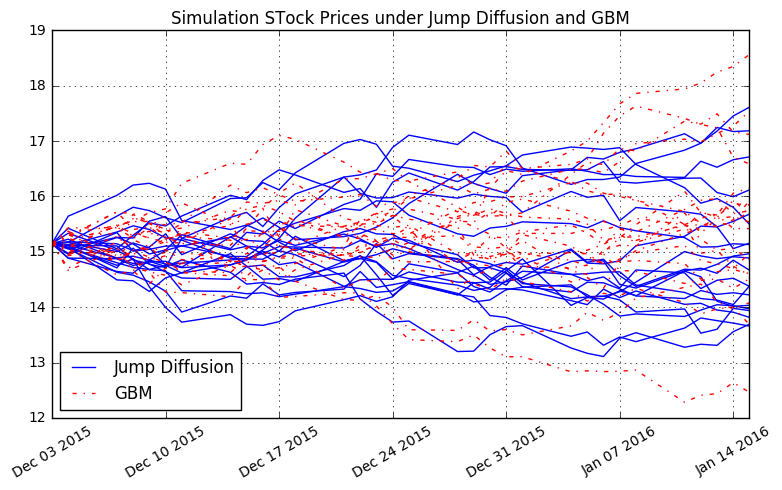

In [5]:
me_gbm = market_environment('me_gbm', dt.datetime(2015, 12, 3))

me_gbm.add_constant('initial_value', 15.15)
me_gbm.add_constant('volatility', 0.229)
me_gbm.add_constant('final_date', dt.datetime(2016, 1, 15))
me_gbm.add_constant('currency', 'US')
me_gbm.add_constant('frequency', 'B')
me_gbm.add_constant('paths', 5000)
me_gbm.add_constant('short_rate', 0.00268)

me_jd = market_environment('me_jd', dt.datetime(2015, 12, 3))

# add jump diffusion specific parameters
me_jd.add_constant('lambda', 0)
me_jd.add_constant('mu', 0.0211072)
me_jd.add_constant('delta', 0.065193)
me_jd.add_environment(me_gbm)

jd = jump_diffusion('jd', me_jd)
jd.generate_time_grid()

# generate Jump Difussion Process stock path
jd.generate_paths()
path1 = jd.instrument_values

# Geometric Brownian Motion (lamb = 0 under jump diffusion)
jd.update(lamb=0)

# generate Geometric Brownian Motion stock path
jd.generate_paths()
path2 = jd.instrument_values

plt.figure(figsize=(9,5))
p1 = plt.plot(jd.time_grid, path1[:, :20], 'b', label = 'Jump Diffusion')
p2 = plt.plot(jd.time_grid, path2[:, :20], 'r-.', label = 'GBM')
plt.grid(True)
plt.legend([p1[0], p2[0]], ['Jump Diffusion', 'GBM'], loc=3)
#plt.gca().add_artist(l1)
plt.xticks(rotation=30)
plt.title('Simulation STock Prices under Jump Diffusion and GBM')
plt.show()


3) Comparison of option prices

In [6]:
list_of_K = np.array(range(12,19))
# market_option_price = [3.72, 2.9,1.65,0.85,0.46,0.21,0.11]

# market option mid price
market_option_price = [3.3, 2.37, 1.55, 0.86, 0.41, 0.195, 0.1]
jump_option_price = []
bl_option_price = []

for i in range(len(list_of_K)):
    jump_option_price.append(np.mean(np.maximum(path1[31]-list_of_K[i],\
                                                 np.zeros(len(path1[31])))\
                                                *math.exp(-0.0035350*31/252)))
    bl_option_price.append(np.mean(np.maximum(path2[31]-list_of_K[i],\
                                                 np.zeros(len(path1[31])))\
                                                *math.exp(-0.0035350*31/252)))
    

# provide a DataFrame with all the price
Optionframe = DataFrame(np.array([market_option_price, jump_option_price, bl_option_price]), \
                        index=['Market Price','Jump Price','BL Price'],\
                        columns=[['Strike Price'] * 7,\
                                 ['12','13','14','15','16','17','18']])


In [7]:
# Table of comparison of different option prices

Optionframe

Strike Price                                                    \
                       12        13        14        15        16        17   
Market Price     3.300000  2.370000  1.550000  0.860000  0.410000  0.195000   
Jump Price       3.157315  2.169280  1.255085  0.565993  0.186630  0.044254   
BL Price         3.152979  2.163857  1.243699  0.549708  0.172723  0.039548   

                        
                    18  
Market Price  0.100000  
Jump Price    0.009847  
BL Price      0.006635

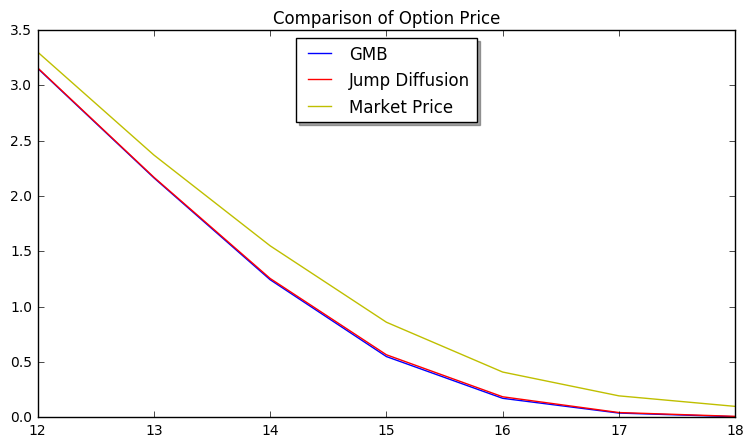

In [8]:
# Line chart comparison

plt.figure(figsize=(9,5))
plt.plot(list_of_K, bl_option_price,'b',label = 'GMB')
plt.plot(list_of_K, jump_option_price,'r',label = 'Jump Diffusion')
plt.plot(list_of_K, market_option_price,'y',label = 'Market Price')
plt.legend(loc='upper center', shadow=True)
plt.title('Comparison of Option Price')

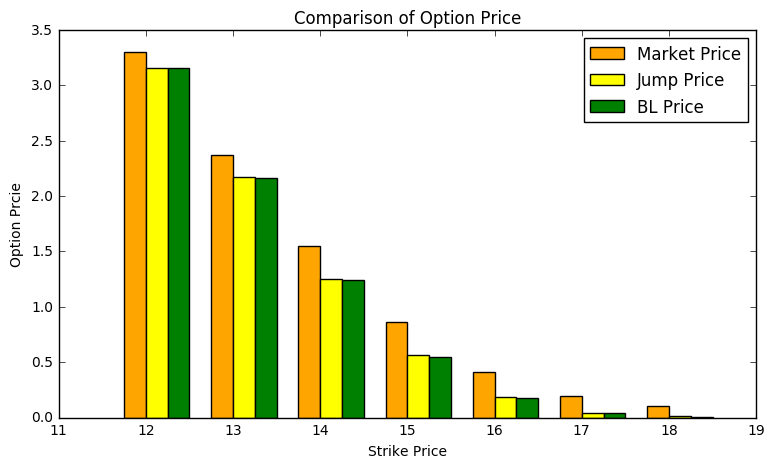

In [9]:
# Histogram of comparison

plt.figure(figsize=(9,5))
width = 0.25
rects1 = plt.bar(np.arange(12,19)-width, market_option_price,width, color='orange')
rects2 = plt.bar(np.arange(12,19), jump_option_price,width, color='yellow')
rects3 = plt.bar(np.arange(12,19)+width, bl_option_price,width, color='green')

# axis and labels
plt.title('Comparison of Option Price')
plt.xlabel('Strike Price')
plt.ylabel('Option Prcie')
plt.legend((rects1,rects2,rects3),('Market Price', 'Jump Price','BL Price'))
